**Aim**

The aim of this project is to prepare tweets to train a model used to classify tweets into sentiments. This model is then used to sentiment classify new/unseen tweets from Twitter's API.

Possible risk is that model will not be well-stocked in what is usually classified as positive or negative sentiment. So if this is the case, there is a risk that the model will predict poorly on unseen data. 

**Data Origin and Description**

**Data Set is from "Sentiment140. More information about the dataset
can be found here*:

http://help.sentiment140.com/for-students/
    
The dataset can be directly downloaded from here:
    
http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

Description of data's fields

0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive) <br />
1 - the id of the tweet (2087)<br />
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)<br />
3 - the query (lyx). If there is no query, thven this value is NO_QUERY.<br />
4 - the user that tweeted (robotickilldozr)<br />
5 - the text of the tweet (Lyx is cool)

**Initial Peak into the Data**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
#Add column names to dataset

cols = ['sentiment', 'id', 'date', 'query', 'user', 'tweet_txt']

In [7]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header = None, names = cols)

In [8]:
df.head(5)

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                          tweet_txt  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment    1600000 non-null int64
id           1600000 non-null int64
date         1600000 non-null object
query        1600000 non-null object
user         1600000 non-null object
tweet_txt    1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

Training dataset consists of 1.6 million tweets. Also, data has no null values. 
And the dataset only comprises of extreme sentiment values (0 and 4). 2 does not exist.
Lastly, based on the value_counts, this dataset is split evenly with 50% have 0 sentiment
and the other 50% having positive sentiment. The advantage here is that there is no skewed data, which is ideal for training data. In order to predict well on unseen data, the training data needs to have even represented classes. Otherwise, the prediction accuract goes down when the 
data only has one class represented well.

In order to set up training data to feed into M.L. algorithm, appropriate
X and y values need to be set up. The X column will be the twitter_txt column.
And the y value will be the sentiment column.

In [11]:
df.drop(['id', 'date', 'query', 'user'], axis = 1, inplace = True)

In [12]:
df.head()

sentiment                                          tweet_txt
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Appropriate columns for M.L. algoritm are retained.

One thing to make sure is how negative (0) and positive (4) sentiments are distributed
in Training dataset. After doing some exploratory data analysis using .head()
and .tail(), it seemed like the top of the dataset comprised of all negative sentiments
and the bottom of the dataset comprised of all the positive sentiments.
This can be confirmed by looking at the split in the dataset (index = 800000). And at a
closer look, we can take a look at each index's sentiment value. 

In [13]:
df.loc[790000], df.loc[800000]

(sentiment                                   0
 tweet_txt    Virpi's last day.  Busy as tits.
 Name: 790000, dtype: object,
 sentiment                                               4
 tweet_txt    I LOVE @Health4UandPets u guys r the best!! 
 Name: 800000, dtype: object)

In [14]:
df[df.sentiment == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [15]:
df[df.sentiment == 4].index

Int64Index([ 800000,  800001,  800002,  800003,  800004,  800005,  800006,
             800007,  800008,  800009,
            ...
            1599990, 1599991, 1599992, 1599993, 1599994, 1599995, 1599996,
            1599997, 1599998, 1599999],
           dtype='int64', length=800000)

It is confirmed that the first half of the Training dataset is all negative
sentiments. And the last half of the Training dataset is all positive sentiments.

In order to prepare the data for computation, need to convert postive sentiment value (4) to 1.

In [16]:
df['sentiment'] = df['sentiment'].map({0:0, 4:1})

In [17]:
df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

**Data Preparation**

In [18]:
df['pre_clean_len'] = [len(t) for t in df.tweet_txt]

**Data Dictionary - first draft**

In [19]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.tweet_txt.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


In order to observe the overall dist. of tweet_txt string lengths, plot pre_clean_len with boxplot.

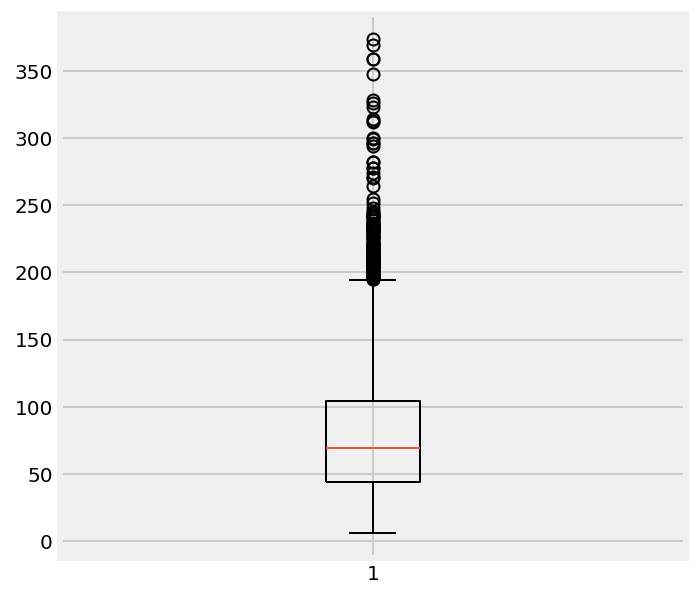

In [20]:
fig, ax = plt.subplots(figsize = (5,5))
plt.boxplot(df.pre_clean_len)
plt.show()

The max length/character limit on each twitter_txt was 140. 
However, the graph above shows otherwise. Time to elminate any tags, misc.
from each text. 

In [21]:
df[df.pre_clean_len > 140].head(10)

sentiment                                          tweet_txt  \
213           0  Awwh babs... you look so sad underneith that s...   
226           0  Tuesday�ll start with reflection �n then a lec...   
279           0  Whinging. My client&amp;boss don't understand ...   
343           0  @TheLeagueSF Not Fun &amp; Furious? The new ma...   
400           0  #3 woke up and was having an accident - &quot;...   
464           0  My bathtub drain is fired: it haz 1 job 2 do, ...   
492           0  pears &amp; Brie, bottle of Cabernet, and &quo...   
747           0  Have an invite for &quot;Healthy Dining&quot; ...   
957           0  Damnit I was really digging this season of Rea...   
1064          0  Why do I keep looking...I know that what I rea...   

      pre_clean_len  
213             142  
226             141  
279             145  
343             145  
400             144  
464             146  
492             150  
747             141  
957             141  
1064            141

Some tweet_txt's are indeed longer than 140. So need to eliminate all irrelevant character/strings.

**Data Preparation 1: HTML decoding**

It looks like HTML encoding has not been converted to text, and ended up in text field as '&amp','&quot',etc.
Decoding HTML to general text will be my first step of data preparation. I will use BeautifulSoup for this.

In [22]:
df.tweet_txt[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [23]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.tweet_txt[279], 'lxml')
print example1.get_text()

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


**Data Preparation 2: @mention**

Even though a good feature in the Twitter app, @mention is not relevant for
this project's aim.

In [24]:
df.tweet_txt[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [25]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.tweet_txt[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

**Data Preparation: URL Links**

The same purpose in elimninating URL links as mentioned above for eliminating
@mention.

In [26]:
df.tweet_txt[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [27]:
re.sub('https?://[A-Za-z0-9./]+','',df.tweet_txt[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

**Data Preparation: UTF-8 BOM (Byte Order Mark)**

In [28]:
df.tweet_txt[226]

'Tuesday\xef\xbf\xbdll start with reflection \xef\xbf\xbdn then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [29]:
test = df.tweet_txt[226].decode("utf-8-sig")
test

u'Tuesday\ufffdll start with reflection \ufffdn then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [30]:
test.replace(u"\ufffd", "?")

u'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

**Data Preparation: Hashtag / Numbers**

Hashtag's can provide useful information. So only '#' symbol will be removed.
This will be done along with removing all non-alphabets including numbers.

In [31]:
df.tweet_txt[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [32]:
re.sub("[^a-zA-Z]", " ", df.tweet_txt[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

**Defining data cleaning function**

All the Data Preparation steps will be consolidated in one function. 
Tokenization, stemming/lemmatization, stop words will be addressed later
in the project when creating matrix with either count vectorizer or Tfidf vectorizer.

In [33]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [34]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # Two lines above, during the step letters_only process, unnecessary white spaces were create
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [35]:
test = df.tweet_txt[:100]

In [36]:
test_result = []
for t in test:
    test_result.append(tweet_cleaner(t))

/Users/mindyng/anaconda/lib/python2.7/encodings/utf_8_sig.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if input[:3] == codecs.BOM_UTF8:


In [37]:
test_result

[u'awww that s a bummer you shoulda got david carr of third day to do it d',
 u'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 u'i dived many times for the ball managed to save the rest go out of bounds',
 u'my whole body feels itchy and like its on fire',
 u'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 u'not the whole crew',
 u'need a hug',
 u'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 u'k nope they didn t have it',
 u'que me muera',
 u'spring break in plain city it s snowing',
 u'i just re pierced my ears',
 u'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 u'it it counts idk why i did either you never talk to me anymore',
 u'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 u'i wish i got to watch it with you i miss you and how was the premiere',
 u'hollis deat

In [38]:
nums = [0,400000,800000,1200000,1600000]

In [39]:
%%time
print "Cleaning and parsing the tweets...\n"
clean_tweet_texts = []
for i in xrange(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print "Tweets %d of %d has been processed" % ( i+1, nums[1] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['tweet_txt'][i]))

Cleaning and parsing the tweets...

Tweets 10000 of 400000 has been processed
Tweets 20000 of 400000 has been processed
Tweets 30000 of 400000 has been processed
Tweets 40000 of 400000 has been processed
Tweets 50000 of 400000 has been processed
Tweets 60000 of 400000 has been processed
Tweets 70000 of 400000 has been processed
Tweets 80000 of 400000 has been processed
Tweets 90000 of 400000 has been processed
Tweets 100000 of 400000 has been processed
Tweets 110000 of 400000 has been processed
Tweets 120000 of 400000 has been processed
Tweets 130000 of 400000 has been processed
Tweets 140000 of 400000 has been processed
Tweets 150000 of 400000 has been processed
Tweets 160000 of 400000 has been processed
Tweets 170000 of 400000 has been processed
Tweets 180000 of 400000 has been processed
Tweets 190000 of 400000 has been processed
Tweets 200000 of 400000 has been processed
Tweets 210000 of 400000 has been processed
Tweets 220000 of 400000 has been processed
Tweets 230000 of 400000 has

In [40]:
len(clean_tweet_texts)

400000

In [41]:
%%time
print "Cleaning and parsing the tweets...\n"
for i in xrange(nums[1],nums[2]):
    if( (i+1)%10000 == 0 ):
        print "Tweets %d of %d has been processed" % ( i+1, nums[2] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['tweet_txt'][i]))

Cleaning and parsing the tweets...

Tweets 410000 of 800000 has been processed
Tweets 420000 of 800000 has been processed
Tweets 430000 of 800000 has been processed
Tweets 440000 of 800000 has been processed
Tweets 450000 of 800000 has been processed
Tweets 460000 of 800000 has been processed
Tweets 470000 of 800000 has been processed
Tweets 480000 of 800000 has been processed
Tweets 490000 of 800000 has been processed
Tweets 500000 of 800000 has been processed
Tweets 510000 of 800000 has been processed
Tweets 520000 of 800000 has been processed
Tweets 530000 of 800000 has been processed
Tweets 540000 of 800000 has been processed
Tweets 550000 of 800000 has been processed
Tweets 560000 of 800000 has been processed
Tweets 570000 of 800000 has been processed
Tweets 580000 of 800000 has been processed
Tweets 590000 of 800000 has been processed
Tweets 600000 of 800000 has been processed
Tweets 610000 of 800000 has been processed
Tweets 620000 of 800000 has been processed
Tweets 630000 of 8

In [42]:
len(clean_tweet_texts)

800000

In [43]:
%%time
print "Cleaning and parsing the tweets...\n"
for i in xrange(nums[2],nums[3]):
    if( (i+1)%10000 == 0 ):
        print "Tweets %d of %d has been processed" % ( i+1, nums[3] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['tweet_txt'][i]))

Cleaning and parsing the tweets...

Tweets 810000 of 1200000 has been processed
Tweets 820000 of 1200000 has been processed
Tweets 830000 of 1200000 has been processed
Tweets 840000 of 1200000 has been processed
Tweets 850000 of 1200000 has been processed
Tweets 860000 of 1200000 has been processed
Tweets 870000 of 1200000 has been processed
Tweets 880000 of 1200000 has been processed
Tweets 890000 of 1200000 has been processed
Tweets 900000 of 1200000 has been processed
Tweets 910000 of 1200000 has been processed
Tweets 920000 of 1200000 has been processed
Tweets 930000 of 1200000 has been processed
Tweets 940000 of 1200000 has been processed
Tweets 950000 of 1200000 has been processed
Tweets 960000 of 1200000 has been processed
Tweets 970000 of 1200000 has been processed
Tweets 980000 of 1200000 has been processed
Tweets 990000 of 1200000 has been processed
Tweets 1000000 of 1200000 has been processed
Tweets 1010000 of 1200000 has been processed
Tweets 1020000 of 1200000 has been pro

In [44]:
len(clean_tweet_texts)

1200000

In [45]:
%%time
print "Cleaning and parsing the tweets...\n"
for i in xrange(nums[3],nums[4]):
    if( (i+1)%10000 == 0 ):
        print "Tweets %d of %d has been processed" % ( i+1, nums[4] )                                                                    
    clean_tweet_texts.append(tweet_cleaner(df['tweet_txt'][i]))

Cleaning and parsing the tweets...

Tweets 1210000 of 1600000 has been processed
Tweets 1220000 of 1600000 has been processed
Tweets 1230000 of 1600000 has been processed
Tweets 1240000 of 1600000 has been processed
Tweets 1250000 of 1600000 has been processed
Tweets 1260000 of 1600000 has been processed
Tweets 1270000 of 1600000 has been processed
Tweets 1280000 of 1600000 has been processed
Tweets 1290000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1

In [46]:
len(clean_tweet_texts)

1600000

**Saving cleaned up data as .csv**

In [47]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['tweet_txt'])
clean_df['target'] = df.sentiment
clean_df.head()

tweet_txt  target
0  awww that s a bummer you shoulda got david car...       0
1  is upset that he can t update his facebook by ...       0
2  i dived many times for the ball managed to sav...       0
3     my whole body feels itchy and like its on fire       0
4  no it s not behaving at all i m mad why am i h...       0

In [48]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [49]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

/Users/mindyng/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


tweet_txt  target
0  awww that s a bummer you shoulda got david car...       0
1  is upset that he can t update his facebook by ...       0
2  i dived many times for the ball managed to sav...       0
3     my whole body feels itchy and like its on fire       0
4  no it s not behaving at all i m mad why am i h...       0